# **Tutorial 4: Quantifying Uncertainty in Projections**

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In the previous tutorial, we took the data from a diverse set of CMIP6 models and we showed that the projections are different from one to another due to different physics, different numerics and different discretizations. In this tutorial, we will learn about the uncertainty associated with future climate projections by exploring the variability across CMIP6 model data. We will establish a 'likely' range of projections as defined by the IPCC. 

By the end of this tutorial, you will be able to 
- apply IPCC confidence levels to climate model data
- quantify the uncertainty associated with these projections.


# **Setup**

    



In [1]:
# !pip install condacolab &> /dev/null        
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [2]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline


In [5]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim='time')

In [6]:
# @title Video 4: Quantifying Uncertainty in Projections 
#Tech team will add code to format and display the video

# **Section 1: Loading the Data**

First, lets load the datasets that we used in the previous tutorial, which spanned 5 models and the experiments spanning the historical period, in addition to the low-emissions and high-emissions future scenarios



In [7]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five models and three experiments
# there are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']
experiment_ids = ['historical', 'ssp126', 'ssp585']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


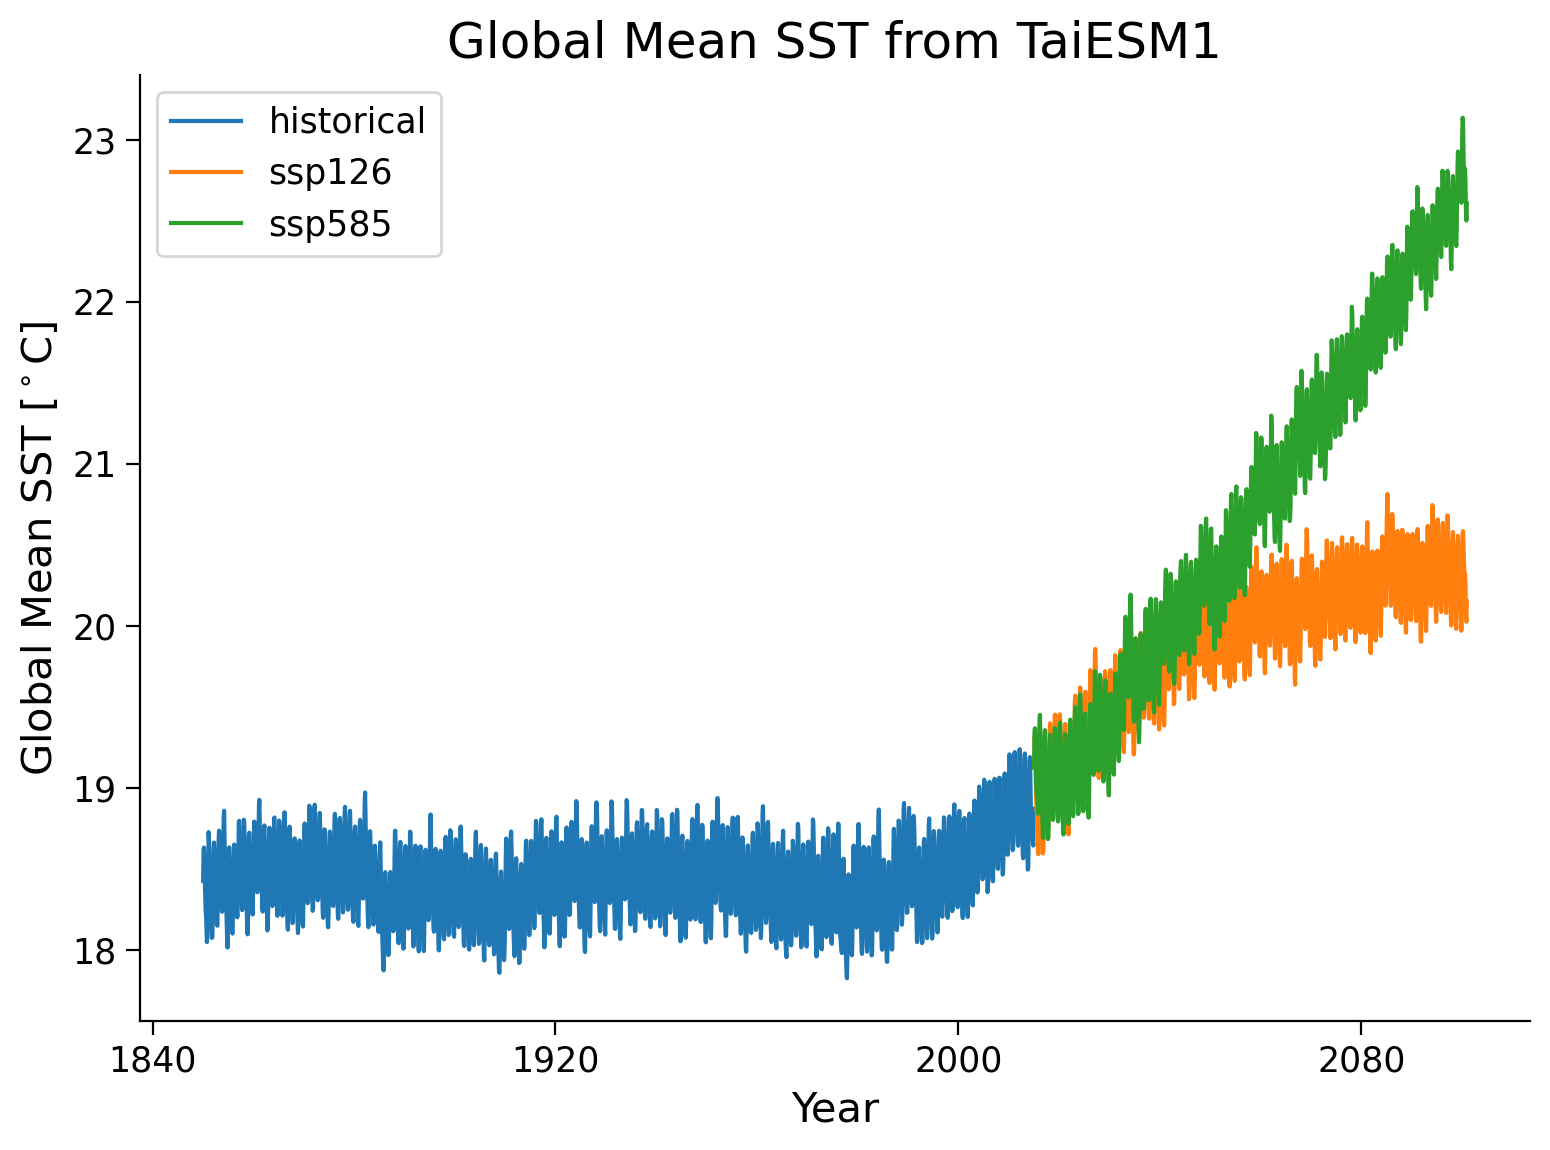

In [8]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = experiment_ids,
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)

cat_area = col.search(
    source_id=source_ids,
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)

cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()
 
plot_historical_ssp126_combined(dt_gm)

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

# **Section 2: Quantifying Uncertainty in a CMIP6 Multi-model Ensemble**

Let's create a multi-model ensemble containing data from multiple CMIP6 models, which we can use to quantify our confidence in future projected sea surface temperature change under low- and high-emissions scenarios. 

Specifically, your goal is to create a *likely* range of future projected conditions. The IPCC uncertainty language defines the *likely* range as the middle 66% of model results (i.e., ignoring the upper 17% and lower 17% of results)

### **Coding Exercise 2.1: Display Multi-model Ensemble Data with IPCC Uncertainty Bands**

Complete the following code to plot:


1.   Shading to display the likely range of temperatures for the CMIP6 historical and projected data (include both *SSP1-2.6* and *SSP5-8.5*). *da_upper* and *da_lower* are the boundaries of this shaded region
2.   The multi-model mean temperature



In [9]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Plot the multi-model mean projections, and their likely range under different experiments/scenarios")
#################################################

for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = dt_gm_anomaly[model][experiment].ds.tos.coarsen(time=12).mean().assign_coords(source_id=model)
        datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp126 
    da = xr.concat(datasets, dim='source_id', join='override').squeeze()
    x = da.time.data
    # calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(...)
    # calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(...) 
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
    # calculate the multi-model mean at each time within each experiment
    da.mean(...).plot(color=color, label=experiment,)
plt.title('Global Mean SST Anomaly from five-member CMIP6 ensemble (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

plt.show()

NotImplementedError: Student exercise: Plot the multi-model mean projections, and their likely range under different experiments/scenarios

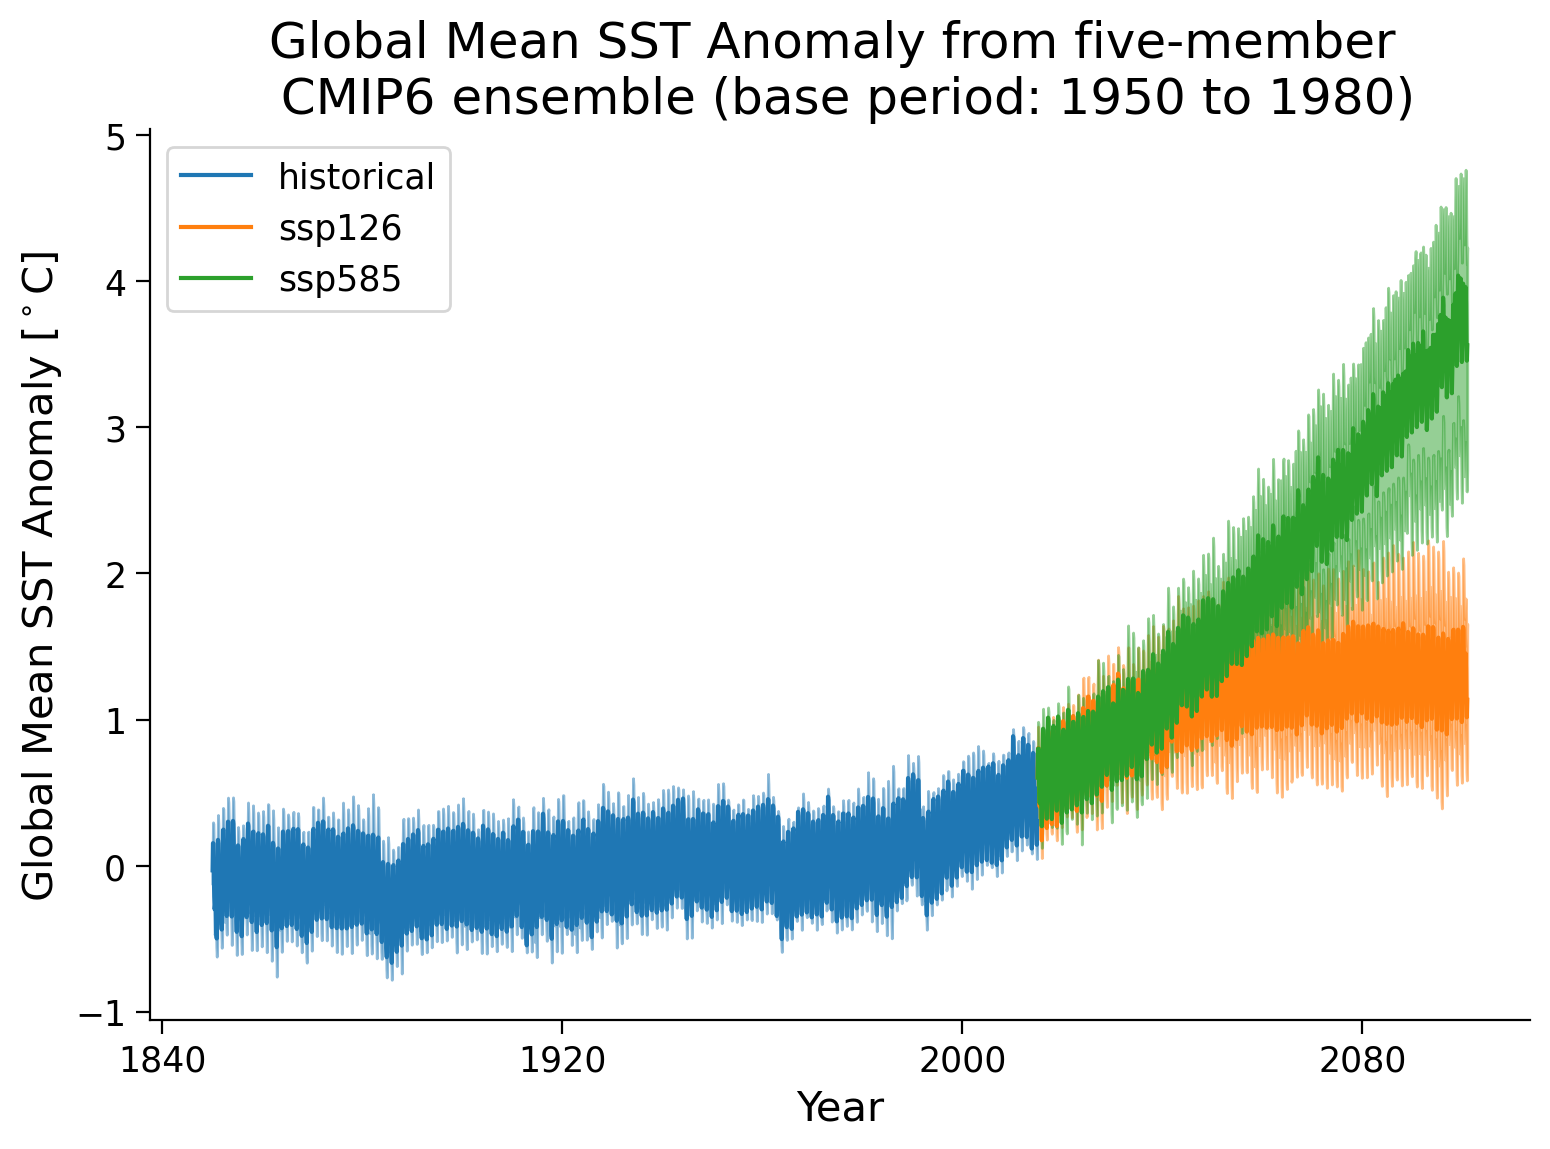

In [9]:
# to_remove solution
for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = dt_gm_anomaly[model][experiment].ds.tos.assign_coords(source_id=model)
        datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp126 
    da = xr.concat(datasets, dim='source_id', join='override').squeeze()
    x = da.time.data
    # calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(0.17, dim='source_id') 
    # calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(0.83, dim='source_id') 
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
    # calculate the multi-model mean at each time within each experiment
    da.mean('source_id').plot(color=color, label=experiment,) 
plt.title('Global Mean SST Anomaly from five-member \n CMIP6 ensemble (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

### **Questions 2.1**

1.   What does this figure tell you about how the multi-model uncertainty compares to projected physical changes in the global mean SST? 
2.   Is this the same for both scenarios?
3.   For a 5-model ensemble like this, how do the *likely* ranges specifically relate to the 5 individual model temperatures at a given time?

In [1]:
# to_remove explanation

"""
1. Under both of these scenarios (SSP1-2.6 and SSP5-8.5), the projected warming of the climate is greater than the multi-model uncertainty.
2. The warming is greater for SSP5-8.5, but so is the multi-model uncertainty, so the relative size of physical changes and multi-model uncertainty is comparable across both scenarios.
3. The likely range includes the middle 66% of model results at a given time. For 5 models this means the ranges encompass the middle 3 models (i.e., they exclude the highest and lowest cvalued model at each time).
""";

# **Summary**
In this tutorial, we have delved into quantifying the uncertainty of future climate projections by analyzing differences across various CMIP6 models. We learned to apply IPCC's confidence levels to establish a 'likely' range of projections, which refers to the middle 66% of model results. 